In [6]:
!pip install xgboost
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [imblearn]


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve,roc_auc_score,classification_report, confusion_matrix, average_precision_score, auc

In [9]:


df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.info() , df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(None,
 Time      0
 V1        0
 V2        0
 V3        0
 V4        0
 V5        0
 V6        0
 V7        0
 V8        0
 V9        0
 V10       0
 V11       0
 V12       0
 V13       0
 V14       0
 V15       0
 V16       0
 V17       0
 V18       0
 V19       0
 V20       0
 V21       0
 V22       0
 V23       0
 V24       0
 V25       0
 V26       0
 V27       0
 V28       0
 Amount    0
 Class     0
 dtype: int64)

# Exploratory Data Analysis

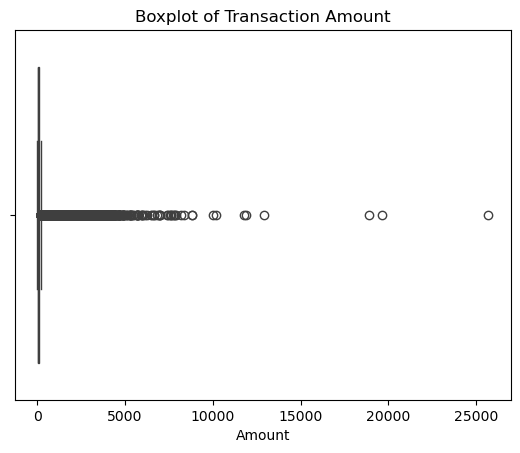

In [13]:
sns.boxplot(x="Amount",data=df)
plt.title('Boxplot of Transaction Amount')
plt.xlabel('Amount')
plt.show()


 
* Most of the transactions seems to be small because the boxplot graph is compressed to 0.


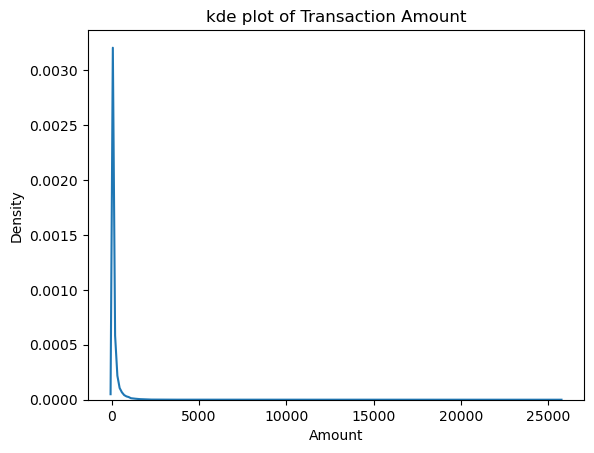

In [18]:
sns.kdeplot(x='Amount',data=df)
plt.title('kde plot of Transaction Amount')
plt.xlabel('Amount')
plt.show()


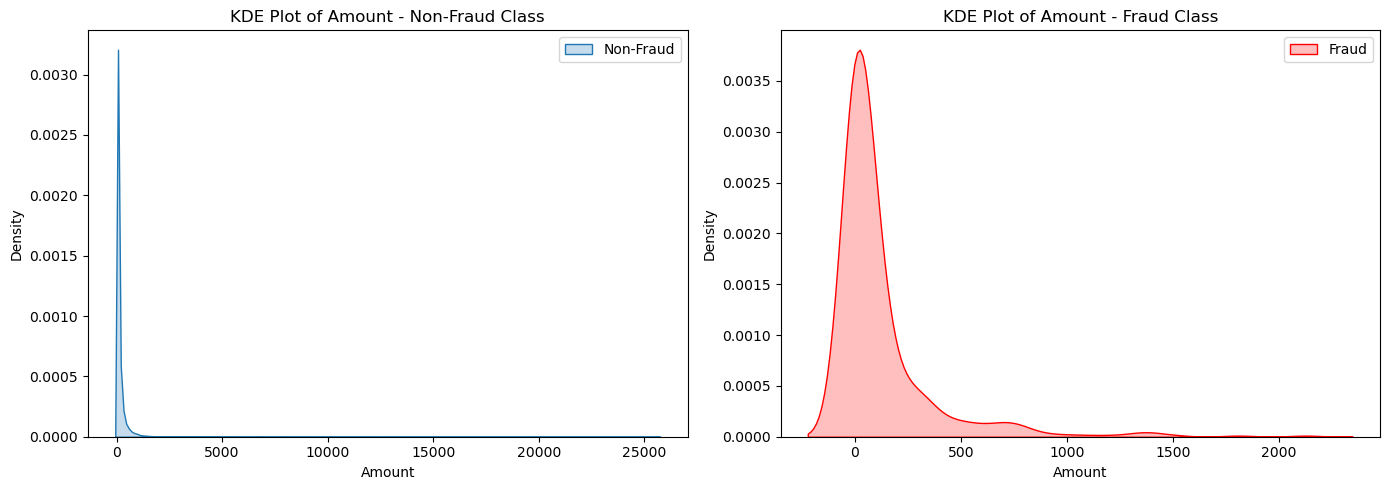

In [24]:


fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# KDE for Non-Fraud
sns.kdeplot(data=df[df['Class'] == 0]['Amount'], label='Non-Fraud', fill=True, ax=axs[0])
axs[0].set_title('KDE Plot of Amount - Non-Fraud Class')
axs[0].set_xlabel('Amount')
axs[0].legend()

# KDE for Fraud
sns.kdeplot(data=df[df['Class'] == 1]['Amount'], label='Fraud', fill=True, ax=axs[1], color = "red")
axs[1].set_title('KDE Plot of Amount - Fraud Class')
axs[1].set_xlabel('Amount')
axs[1].legend()

plt.tight_layout()
plt.show()


In [38]:
# df["Class"].value_counts()



df.groupby("Class").size().reset_index(name="counts")

,Class,counts
0,0,284315
1,1,492


In [25]:
df['Hour'] = (df['Time'] // 3600) % 24


In [40]:
fraud = df[df["Class"]==1]
non_fraud = df[df["Class"]==0]
fraud.shape

(492, 32)

In [44]:
fraud_count_per_hr = fraud.groupby("Hour").size().reset_index(name="Sum of frauds")
fraud_count_per_hr

,Hour,Sum of frauds
0,0.0,6
1,1.0,10
2,2.0,57
3,3.0,17
4,4.0,23
5,5.0,11
6,6.0,9
7,7.0,23
8,8.0,9
9,9.0,16


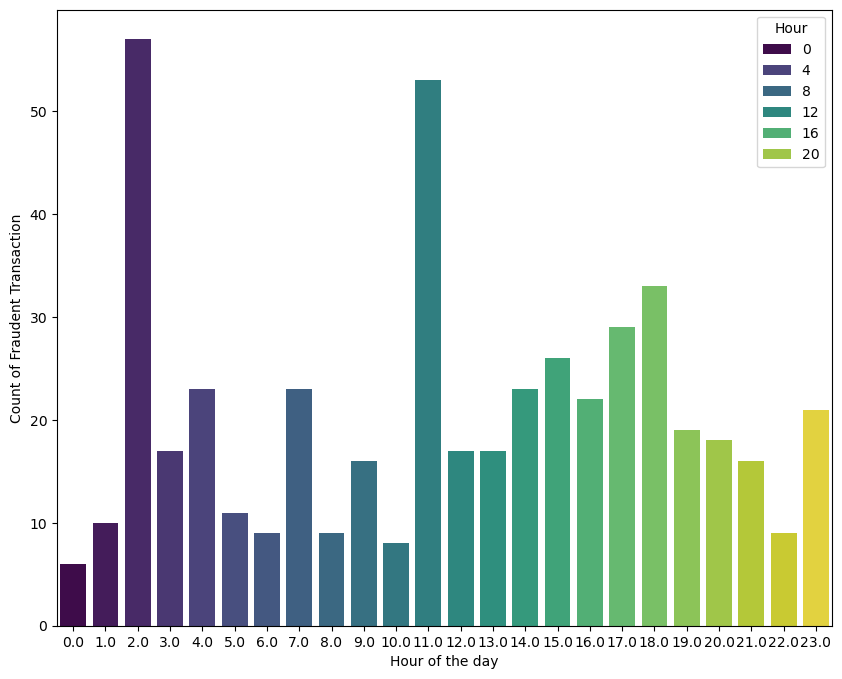

In [51]:

plt.figure(figsize = (10,8))
sns.barplot(x = fraud_count_per_hr["Hour"], y = fraud_count_per_hr["Sum of frauds"],hue =fraud_count_per_hr["Hour"] , palette="viridis" )
plt.xlabel("Hour of the day")
plt.ylabel("Count of Fraudent Transaction")
plt.show()

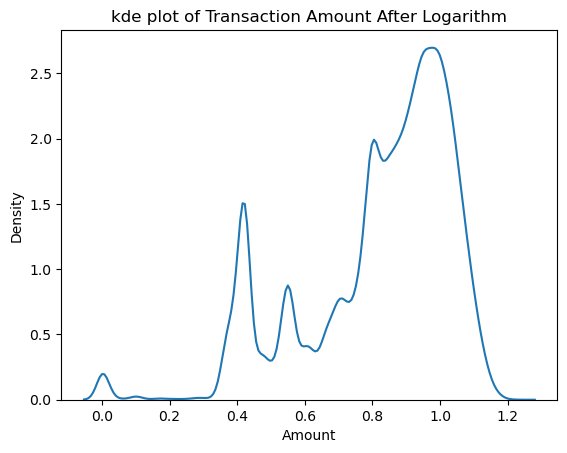

In [54]:
df['Amount'] = np.log1p(df['Amount'])
sns.kdeplot(x='Amount',data=df)
plt.title('kde plot of Transaction Amount After Logarithm')
plt.xlabel('Amount')
plt.show()

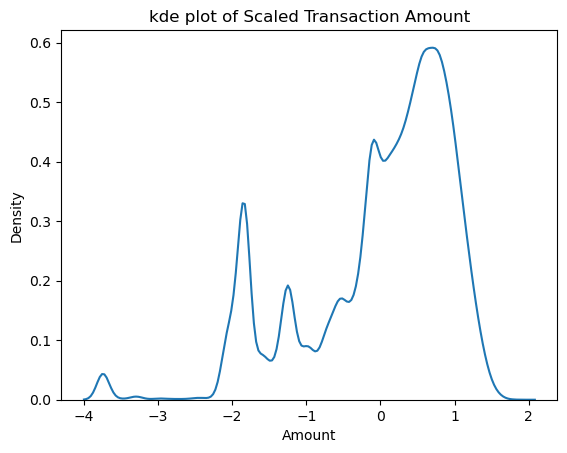

In [55]:
scaler = StandardScaler()
df['ScaledAmount'] = scaler.fit_transform(df[['Amount']])


sns.kdeplot(x='ScaledAmount',data=df)
plt.title('kde plot of Scaled Transaction Amount')
plt.xlabel('Amount')
plt.show()

In [56]:
df['Hour_Scaled'] = scaler.fit_transform(df[['Hour']])

In [57]:
df.drop(columns=['Amount','Hour','Time'],inplace=True)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,ScaledAmount,Hour_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.929401,-2.40693
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.987456,-2.40693
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.156990,-2.40693
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.876580,-2.40693
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.705958,-2.40693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-2.056906,1.53423
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,0.324113,1.53423
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,0.696092,1.53423
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.113243,1.53423


In [58]:
X=df.drop(columns=['Class'],axis=1)
y=df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neg, pos = np.bincount(y)
scale_pos_weight = neg / pos
print(f"Scale pos weight: {scale_pos_weight}")

Scale pos weight: 577.8760162601626


In [60]:
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    
    eval_metric='logloss'
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [61]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
auprc = average_precision_score(y_test, y_proba)
print(f"AUPRC Score: {auprc:.4f}")

Confusion Matrix:
 [[56726   138]
 [   12    86]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.88      0.53        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9798710564698587
AUPRC Score: 0.8412
